## Model 1

This first model consists of a simple 3D autoencoder with 2 conv3D and 2 conv3DTranspose. Compression ratio is (2^3)^2 = 64 divided across 20 filters, that would make: 64/20 = 3.2 = CP. It's a low ratio.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from keras.callbacks import LearningRateScheduler
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
from collections import OrderedDict
from lossycomp.dataLoader import DataGeneratorAll, data_preprocessing, split_data
from lossycomp.utils import decay_schedule

In [2]:
model = models.Sequential()
model.add(layers.Conv3D(10, (4, 4, 4), activation='relu', strides=2, input_shape=(12, 40, 40, 1), padding="same", data_format = "channels_last"))
model.add(layers.Conv3D(20, (4, 4, 4), strides=2, padding="same", activation='relu'))
model.add(layers.Conv3DTranspose(10, (4, 4, 4), strides=2, padding="same", activation='relu'))
model.add(layers.Conv3DTranspose(1, (4, 4, 4), strides=2, padding="same", activation = None))

In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 6, 20, 20, 10)     650       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 3, 10, 10, 20)     12820     
_________________________________________________________________
conv3d_transpose (Conv3DTran (None, 6, 20, 20, 10)     12810     
_________________________________________________________________
conv3d_transpose_1 (Conv3DTr (None, 12, 40, 40, 1)     641       
Total params: 26,921
Trainable params: 26,921
Non-trainable params: 0
_________________________________________________________________


In [4]:
model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

In [5]:
import dask

dask.config.set(**{'array.slicing.split_large_chunks': False})

file = '/lsdf/kit/scc/projects/abcde/1979/*/ERA5.pl.temperature.nc'
region = "germany"
var = OrderedDict({'t': 1000})

z, mean, std = data_preprocessing(file, var, region)

train, test = split_data(z, 0.70)

leads = dict(time = 12, longitude=40, latitude=32, level=1)

dg_train = DataGeneratorAll(train, leads, batch_size=32, load=True, shuffle=True, mean= mean, std=std) 

dg_test = DataGeneratorAll(test, leads, batch_size=32, load=True, shuffle=False, mean= mean, std=std)

Loading data into RAM
Loading data into RAM


In [6]:
lr_scheduler = LearningRateScheduler(decay_schedule)

In [7]:
history = model.fit(dg_train, validation_data = dg_test, epochs=100, callbacks=[lr_scheduler])

Epoch 1/100
191/191 [==============================] - 3s 16ms/step - loss: 0.2007 - val_loss: 0.0450
Epoch 2/100
191/191 [==============================] - 3s 15ms/step - loss: 0.0185 - val_loss: 0.0258
Epoch 3/100
191/191 [==============================] - 3s 15ms/step - loss: 0.0109 - val_loss: 0.0205
Epoch 4/100
191/191 [==============================] - 3s 15ms/step - loss: 0.0084 - val_loss: 0.0182
Epoch 5/100
191/191 [==============================] - 3s 15ms/step - loss: 0.0091 - val_loss: 0.0150
Epoch 6/100
191/191 [==============================] - 3s 15ms/step - loss: 0.0059 - val_loss: 0.0135
Epoch 7/100
191/191 [==============================] - 3s 15ms/step - loss: 0.0055 - val_loss: 0.0127
Epoch 8/100
191/191 [==============================] - 3s 15ms/step - loss: 0.0054 - val_loss: 0.0117
Epoch 9/100
191/191 [==============================] - 3s 14ms/step - loss: 0.0045 - val_loss: 0.0110
Epoch 10/100
191/191 [==============================] - 3s 15ms/step - loss: 0.004

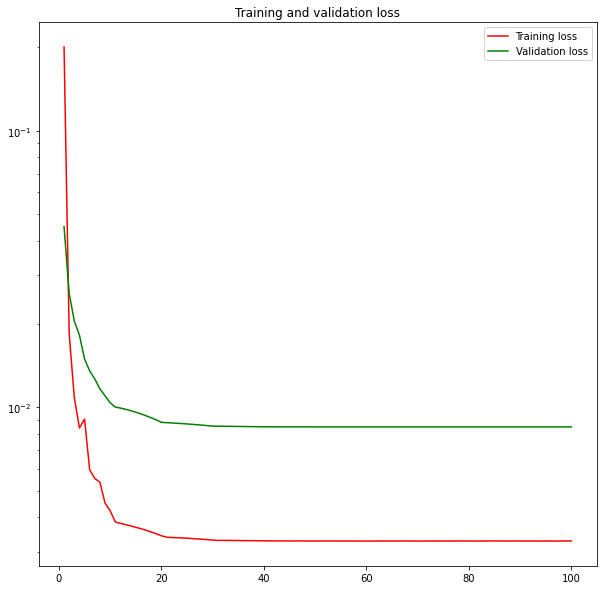

In [8]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

f = plt.figure(figsize=(10,10))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.yscale('log')
plt.title('Training and validation loss')
plt.legend()

plt.show()

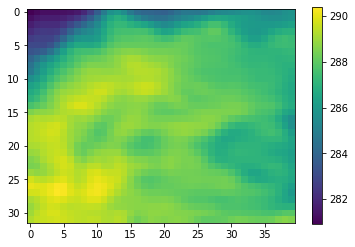

In [9]:
fig, ax = plt.subplots()
a = dg_train.__getitem__(2)[0] 
bb = plt.imshow(a[0,10,:,:,0]  * std + mean,  cmap='viridis')
fig.colorbar(bb, orientation='vertical')
plt.show()

In [10]:
result = model(np.expand_dims(a[0], axis=0)).numpy()

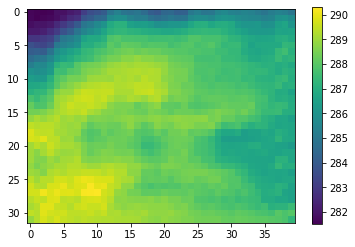

In [11]:
fig, ax = plt.subplots()
bb = plt.imshow((result[0,10,:,:,0] * std + mean))
fig.colorbar(bb, orientation='vertical')
plt.show()

In [18]:
test = xr.open_mfdataset('/lsdf/kit/scc/projects/abcde/1979/*/ERA5.pl.temperature.nc', combine='by_coords')
test_data = test.sel(time=slice('1979-11-14T16:00:00','1979-11-15T03:00:00'),level = slice(978,1000), longitude=slice(6,15.75), latitude=slice(55.5,45.75))
test_data = test_data.transpose('time', 'latitude', 'longitude', 'level')
# Normalize
mean = test_data['t'].mean(('time', 'latitude', 'longitude')).compute()
std = test_data['t'].std('time').mean(('latitude', 'longitude')).compute() 
test_data = (test_data['t'] - mean) / std
test_data = np.expand_dims(test_data.values, axis=0)
test_data.shape


(1, 12, 40, 40, 1)

## Results

Original:

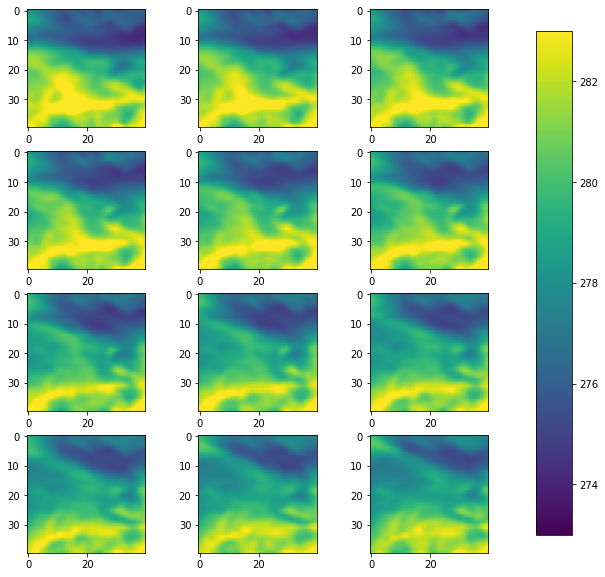

In [27]:
fig, ax = plt.subplots(4,3, figsize=(10,10))
count = 0
for i in range(4):
    for j in range(3):
        img = test_data[0,count,:,:,0] *std.values[0] + mean.values[0]
        im = ax[i, j].imshow(img,  vmin=273, vmax=283)
        count=count +1

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
plt.colorbar(im,  cax=cbar_ax)
plt.show()

Decompressed:

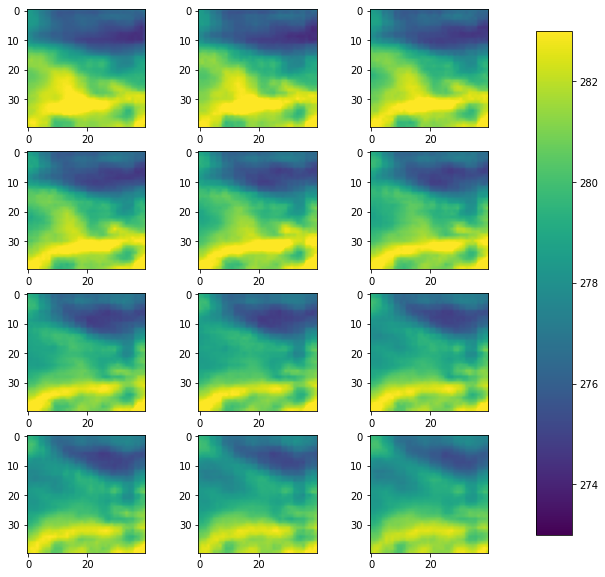

In [28]:
result2 = model(test_data).numpy()

fig, ax = plt.subplots(4,3, figsize=(10,10))

count = 0
for i in range(4):
    for j in range(3):
        img = result2[0,count,:,:,0] *std.values[0] + mean.values[0]
        im = ax[i, j].imshow(img,  vmin=273, vmax=283)
        count=count +1

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
plt.colorbar(im,  cax=cbar_ax)
plt.show()

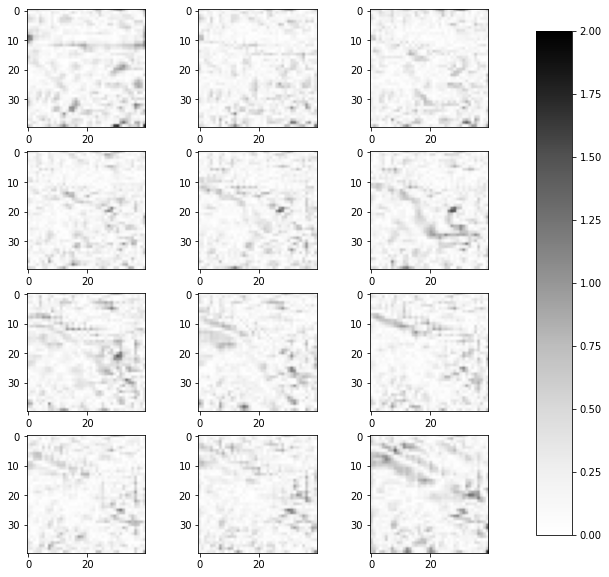

In [31]:
a = result2*std.values[0] + mean.values[0]
b = test_data*std.values[0] + mean.values[0]

result3 = np.absolute(a-b)

fig, ax = plt.subplots(4, 3, figsize=(10,10))
count = 0
for i in range(4):
    for j in range(3):
        img = result3[0,count,:,:,0] 
        im = ax[i, j].imshow(img, cmap = 'Greys', vmin=0, vmax=2)
        count = count +1
        
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
plt.colorbar(im,  cax=cbar_ax)
plt.show()